# Reading and displaying medical 3D images

In [2]:
# export
# default_exp basics
import SimpleITK as sitk
import re
import pathlib
import torchvision
from fastai.basics import *

```python
print(sitk.Version())
for name, val in globals().items():
    if isinstance(val, types.ModuleType):
        try: 
            print(val.__name__ + ': ' + val.__version__)
        except:
            pass
            
SimpleITK Version: 2.0.0rc3 (ITK 5.1)
Compiled: Aug 25 2020 15:43:37

re: 2.2.1
torchvision: 0.7.0
platform: 1.0.8
numpy: 1.19.1
csv: 1.0
json: 2.0.9
matplotlib: 3.3.1
requests: 2.24.0
yaml: 5.3.1
pandas: 1.1.1
scipy: 1.5.2
scipy.ndimage: 2.0
torch: 1.6.0
```

Fastai 2 provides support to read and display medical images using pydicom and pillow, however only 2D images can be read. Both fastai and pytorch do not provide supply for 3D images. Therefore custom functions need to be designed. 

### Create a DICOM base class

Fastai already provides PILDicom and TensorDicom. But I believe, since these objects are designed to handle 2D data, using then might lead to problems in later tasks. So a custom Tensor class will be created to be able to use some of the very handy fastai functions.  

`freqhist_bins` and `hist_scaled` are needed to for image normalization

The `retain_type` function from fast ai can be used, to retain the TensorDicom3D type.
```python
retain_type(t, typ = TensorDicom3D)
```

In [3]:
# hide
class TensorDicom3D(Tensor):
    "Base class for 3D Dicom Tensor. Inherits from `torch.Tensor`"

## Read medical 3D images

3D data is stored in a variety of data formats (DICOM, NIfTI, NRRD, Analyze, ...) which should be supported by the image loader. Also DICOM data is often stored as individual slices (DICOM series) and not as a volume. [SimpleITK](https://simpleitk.org/) is a powerfull library which can handle many data formats, including all of the above mentioned and many more. It will therefore be used to read the 3D volumes.  

In [4]:
# export
def read_medical_3d_image(fn: (pathlib.Path, str), div=None, return_scaled=False, return_normalized=False): 
    '''
    Opens a 3D medical file or DICOM series and returns a tensor
    
    Args: 
        fn: file name as string or pathlib.Path
        div: new max for rescaling pixel values. If None, pixels will be rescaled between 0 and 1. 
    '''
    
    if isinstance(fn, str): fn = Path(fn)
        
    if fn.is_dir(): 
        SeriesReader = sitk.ImageSeriesReader()
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        SeriesReader.SetFileNames(dicom_names)
        im = SeriesReader.Execute()
        im = sitk.Cast(im, sitk.sitkInt16)
    
    elif fn.is_file():
        im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkInt16)
    
    else:
        raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))
    
    t = tensor(sitk.GetArrayFromImage(im)).float()
    
    # the array should be the raw pixel values, so no negative values should appear.
    
    if div is not None: 
        t = t/float(div) # Rescales images between 0 and a new max.
    elif not return_normalized:
        t = t/t.max()  # Rescales images between 0 and 1
 
    t = TensorDicom3D(t)
    if return_scaled: t = t.hist_scaled()
        
    if return_normalized and div is None: t = normalize(t)  # should only be executed if no specific max has been defined
        
    return retain_type(t, typ = TensorDicom3D)

## Display 3D images

Data visualisation is very important. Analogous to a radiology workstation it should be possible to display the images in axial, coronal or sagittal reformation. 

In [5]:
# export
def show_one_3d_image(t: (np.ndarray, Tensor), axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, alpha = 1., return_grid = False, add_to_existing = False, **kwargs):
    '''
    Plots 2D slices of a 3D image alongside a prior specified axis. 
    
    Args: 
        t: a 3D numpy.ndarray or torch.Tensor 
        axis: axis to split 3D array to 2D images
        figsize, cmap: passed to plt.imshow
        nrow: passed to torchvision.utils.make_grid
        return_grid: Whether the grid should be returned for further processing or if the plot should be displayed. 
        add_to_existing: if set to true, no new figure will be created. Used for mask overlays
        
    '''
    if t.device.type == 'cuda': t=t.cpu()
        
    if t.ndim < 3 or t.ndim > 4: 
         raise TypeError('Object is not a rank 3 tensor but a rank {} tensor'.format(t.ndim ))
    if t.ndim == 4: 
        w = 'Object is not a rank 3 tensor but a rank {} tensor. Assuming the 1st dimension is a (fake) color channel it will be removed'.format(t.ndim)
        warn(w)    
        t = t[0,:,:,:]
        
    if isinstance(t, np.ndarray): t = tensor(t)
    
    if axis == 1: # is there a nicer, more flexible way?
        t = t.permute(1, 0, 2)
    elif axis == 2:
        t = t.permute(2, 0, 1)
        
        # implement better way to visualize
        
    if t.min() < 0.: t = t-t.min() # shift pixelvalues to positive range, otherwise the negative values will be clipped. 
    
    t = t.unsqueeze(1)/torch.max(t) # rescale the images, makes for a nicer plot 
    grid = torchvision.utils.make_grid(t, nrow = nrow)
    if return_grid: return grid
    if not add_to_existing: plt.figure(figsize=figsize)
    plt.imshow(grid[0,:,:], cmap = cmap, alpha = alpha)

(torch.Size([31, 736, 736]), None)

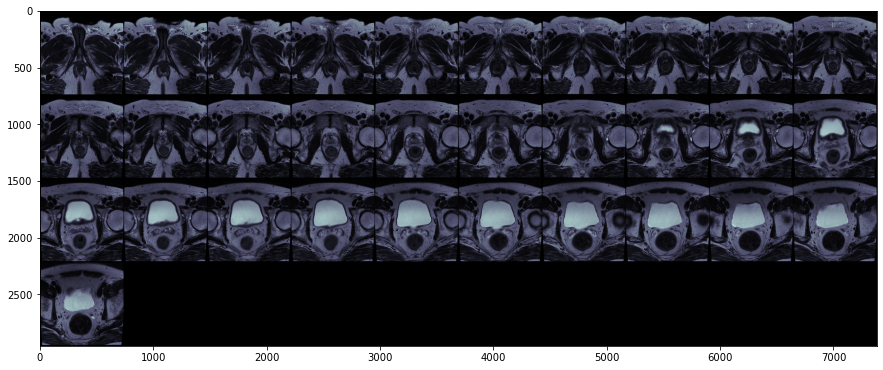

In [6]:
im = read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM')
im.shape, show_one_3d_image(im, axis = 0, nrow = 10)

Sometimes multiple 3D images (e.g. a batch) need to be displayed. With a wrapper for `show_one_3d_image` this is conveniently possible.  

In [7]:
# export
def show_multiple_3d_images(t: Tensor, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, alpha = 1., return_grid = False, add_to_existing=False, **kwargs):
    "displays multiple 3D images (e.g. a batch) by flattening the 4th dimension of the tensor and then calling show_one_3d_image"
    
    if t.ndim not in (4,5): raise TypeError('Object is not a rank 4 or rank 5 tensor but a rank {} tensor'.format(t.ndim))
    if axis > 2: raise ValueError('Axis should be between 0-2, indexing the plane to display each of the multiple 3D images. But axis was {}'.format(axis))

   
    if t.ndim == 4: t =t.reshape(t.size(0)*t.size(1), t.size(2), t.size(3))
    if t.ndim == 5: 
        t = t.permute(1,0,2,3,4)
        t =t.reshape(t.size(0), t.size(1)*t.size(2), t.size(3), t.size(4))
    
    if return_grid: return t
    show_one_3d_image(t, axis = axis, figsize = figsize, cmap = cmap, nrow = nrow, alpha = alpha, add_to_existing = add_to_existing)
    

In [8]:
im.shape

torch.Size([31, 736, 736])

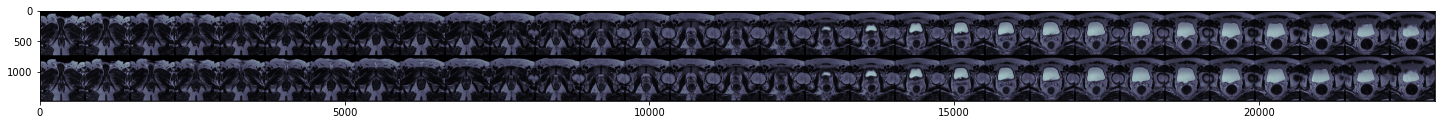

In [9]:
show_multiple_3d_images(torch.stack((im,im)), axis = 0, nrow = 31, figsize = (25, 15))

## Crop and resize 3D images

Often the important areas of the images are also located centrally. For example in CT scans, the skin should always be included in the image, which means that the outer pixels will display only air or the scanner table. These areas can be cropped, effectivly reducing the size of the image without reducing the resolution. 

In [10]:
# export
def crop_3d_tensor(t: Tensor, margins: (int, float), perc_margins = False):
    '''
    Often the regions of interest in the DICOM/NIfTI are centrally locaed in the image. 
    Cropping the margins substantially reduces image size, which makes it possible to keep a higher resolution in the relevant regions. 
    However, absolute cropping of pixel margins might be a problem with differen image resolutions for the same sequenze (e.g. T2 images can be 736x736 px or 448x448). 
     ropping the same margin for differen pixel resolutions could result in unwandet zooming effects. Cropping a percentage margin might be more beneficial.      
    
    Args: 
        t = torch Tensor object
        margins = a tuple of pixels to crop at both sides of each dimension. Either only one value for each dimension is given for a symmetrical crop or two values are given for asymmetric crop.
        perc_margins = whether the margins should be treated as absolute values or precentage values
    '''
    
    if type(margins) is tuple and len(margins) == 3:
        cropx, cropy, cropz = margins
        try: 
            if len(cropx) == 2:
                x1,x2 = cropx
            if len(cropx) == 2:
                y1,y2 = cropy
            if len(cropx) == 2:
                z1,z2 = cropz
        except:
            x1,x2,y1,y2,z1,z2 = cropx, cropx, cropy, cropy, cropz, cropz
            
    else:
        raise ValueError('"margins" must be a tuple with length 3, specifying the new (x,y,z) values of n Pixels to remove from the 3D tensor or representing percentages of pixels to remove from each margin')
    x, y, z = t.shape
    
    if perc_margins: 
        if not all(isinstance(i, float) for i in [x1,x2,y1,y2,z1,z2]): raise ValueError('percentage margins should be a float value between 0 and 0.5')
            
            
        x1,x2,y1,y2,z1,z2 = int(x1*x),int(x2*x),int(y1*y),int(y2*y),int(z1*z),int(z2*z)
    
    t = t[x1:x-x2, y1:y-y2, z1:z-z2]
    return retain_type(t, typ = TensorDicom3D) 

In [11]:
cropped_im_abs = crop_3d_tensor(im, ((0,0),(100,100),(100,100)), perc_margins=False)
cropped_im_perc = crop_3d_tensor(im, ((0.,0.),(0.1,0.1),(0.1,0.1)), perc_margins=True)

im.shape, cropped_im_abs.shape, cropped_im_perc.shape

(torch.Size([31, 736, 736]),
 torch.Size([31, 536, 536]),
 torch.Size([31, 590, 590]))

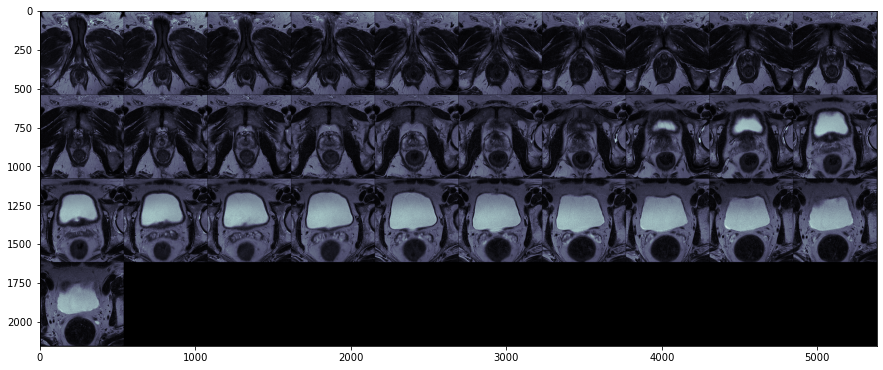

In [12]:
show_one_3d_image(cropped_im_abs)

Medical data has different resolutions. Most CT scans will be at 512x512 px but for MRI the resolution varies. Also the number of slices is different for every scan. To train a neural network all input needs to be the same size, thus a function to resize the images alongside each axis is needed.

In [13]:
# export
def resize_3d_tensor(t: Tensor, new_shape: int):
    """
    A function to resize a 3D image using torch.nn.functional.grid_sample
        
    Args:
        t (Tensor): a Rank 3 Tensor to be resized
        new_dim (int): a tuple with the new x,y,z dimensions of the tensor after resize
        
    Returns:
        a resized `Tensor`. Note that the header with metadata is lost in this process. 
        
    Procedure: 
        [fake RGB] -> [batch dim] -> [flow field] -> [resampling] -> [squeeze]
        
        fake RGB: 
            Create a fake RGB 3D image through generating fake color channels.
        btach dim: 
            add a 5th batch dimension
        flow field: 
            create a flow-field for rescaling:
                a. create a 1D tensor giving a linear progression from -1 to 1
                b. creat a mesh-grid (the flow field) from x,y,z tensors from (a)
                
                Taken form the offical Pytroch documention: 
                    Given an input and a flow-field grid, computes the output using input values and pixel locations from grid.
                    In the spatial (4-D) case, for input with shape (N,C,Hin,Win) and with grid in shape (N, Hout, Wout, 2), the output will have shape (N, C, Hout,Wout)

                    In the case of 5D inputs, grid[n, d, h, w] specifies the x, y, z pixel locations for interpolating output[n, :, d, h, w]. 
                    mode argument specifies nearest or bilinear interpolation method to sample the input pixels.
                
        resampling:  
            resample the input tensor according to the flow field
        squeeze: 
            remove fake color channels and batch dim, returning only the 3D tensor  
    """
    
    if type(new_shape) is tuple and len(new_shape) == 3:
        z,x,y = new_shape # for a reason, I do currently not understand, order of the axis changes from resampling. flipping the order of x,y,z is the current workaround
    else:
        raise ValueError('"new_dim" must be a tuple with length 3, specifying the new (x,y,z) dimensions of the 3D tensor')
    
    t = t.unsqueeze(0) # create fake color channel
    t = t.unsqueeze(0).float() # create batch dim    

    x = torch.linspace(-1, 1, x) # create resampling 'directions' for pixels in each axis
    y = torch.linspace(-1, 1, y)
    z = torch.linspace(-1, 1, z)

    meshx, meshy, meshz = torch.meshgrid((x, y, z)) # 
    grid = torch.stack((meshy, meshx , meshz), 3) # create flow field. x and y need to be switched as otherwise the images are rotated. 
    grid = grid.unsqueeze(0) # add batch dim
    out = F.grid_sample(t, grid, align_corners=True, mode = 'bilinear') # rescale the 5D tensor
    out = out.squeeze().permute(2,0,1).contiguous() # remove fake color channels and batch dim, reorder the image (the Z axis has moved to the back...)
    return retain_type(out, typ = TensorDicom3D)

(torch.Size([100, 50, 50]), None)

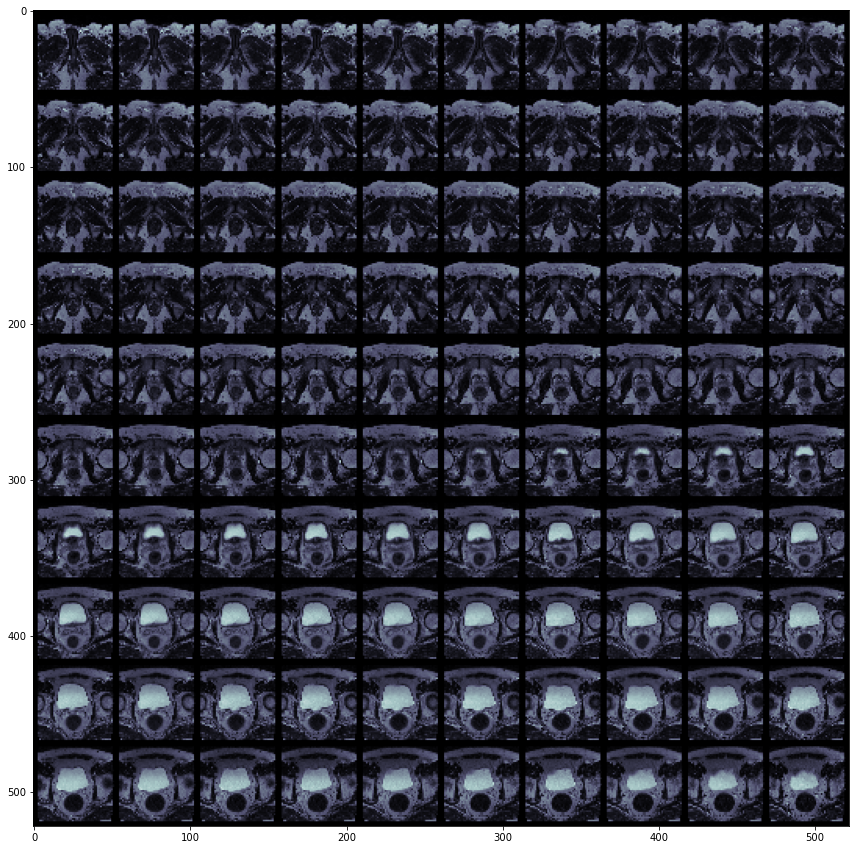

In [14]:
resized_im = resize_3d_tensor(im, (100,50,50))
resized_im.shape, show_one_3d_image(resized_im)

## Normalize images

Especially for MRI the pixel values can vary between scanner types. However, the imagenet stats, as provided by fastai should probably not be used, as they are specfic for color images and not MRI images. The optimal solution would probably be to calculate the stats on the present dataset. 

Statistics of intensity values, pooled across the whole training dataset (raw, unscaled pixel values and pixel values scaled between 0 and 1)

| Statistic                            | ADC       | T2          | T1 map   |
|--------------------------------------|-----------|-------------|----------|
| Pooled Maximum of intensity values   | 3064.2500 | 1369.5652   | 4095     |
| Pooled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Pooled Mean of intensity values      | 511.1060  | 259.1454    | 740.8268 |
| Pooled SD of intensity values        | 488.8707  | 190.2448    | 688.8238 |
| Scaled Maximum of intensity values   | 1.        | 1.          | 1.       |
| Scaled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Scaled Mean of intensity values      | 0.1675    | 0.1918      | 0.1809   |
| Scaled SD of intensity values        | 0.1599    | 0.1409      | 0.1682   |


However, just scaling wiht one mean and std might not be the optimal solution (see the excelent [Kaggle kernel](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) form Jeremy Howard why). Although for MRI images it might be ok, as the pixel values are closer together.

In [15]:
im1 = resize_3d_tensor(read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042280702/T2/DICOM'), (10, 100, 100))
im2 = resize_3d_tensor(read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0041912240/T2/DICOM'), (10, 100, 100))
im1.shape, im2.shape

(torch.Size([10, 100, 100]), torch.Size([10, 100, 100]))

In [41]:
# export 
class TensorDicom3D(Tensor):
    "Base class for 3D Dicom Tensor. Inherits from `torch.Tensor`"
    
    def __init__(self, *args, **kwargs):
        # init the header
        self.metadata = {
            'spacing':  (1,1,1), 
            'origin' : (0,0,0),
            'direction': (0,0,0, 0,0,0, 0,0,0),
            'table': pd.DataFrame({'tags': ['0008|103E'], # cannot pass an empty header to write function, thus add a series description.
                                   'value': ['Object generated from PyTorch `Tensor`']})
        }
    
    def freqhist_bins(self:Tensor, n_bins=100):
        '''
        A function to split the range of pixel values into groups, such that each group has around the same number of pixels. 
        taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
        '''
        imsd = self.view(-1).sort()[0]
        t = torch.cat([tensor([0.001]),
                       torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                       tensor([0.999])])
        t = (len(imsd)*t).long()
        return imsd[t].unique()

    def hist_scaled(self:Tensor, brks=None):
        '''
        Scales a tensor using `freqhist_bins` to values between 0 and 1
        taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
        '''
        if self.device.type=='cuda': return self.hist_scaled_pt(brks)
        if brks is None: brks = self.freqhist_bins()
        ys = np.linspace(0., 1., len(brks))
        x = self.numpy().flatten()
        x = np.interp(x, brks.numpy(), ys)
        x = tensor(x).reshape(self.shape).clamp(0.,1.)
        return retain_type(x, typ = TensorDicom3D)

    def hist_scaled_pt(self:Tensor, brks=None):
        "same as fastai fucntion for PILDicom"
        # Pytorch-only version - switch to this if/when interp_1d can be optimized
        if brks is None: brks = self.freqhist_bins()
        brks = brks.to(self.device)
        ys = torch.linspace(0., 1., len(brks)).to(self.device)
        return self.flatten().interp_1d(brks, ys).reshape(self.shape).clamp(0.,1.)
        
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), **kwargs):
        """
        Open an `3D Image` from path `fn` or create it from an array
        
        Args: 
            cls: Class of the object to create. Should be either TensorDicom3D or TensorMask3D
            fn:  Filename of the medical image file. String or `pathlib.Path`
            
        Returns: 
            An instance of `cls`
            
        """
        if isinstance(fn,ndarray): return cls(fn)
        if isinstance(fn, Tensor): return cls(fn)
        instance, metadata = TensorDicom3D.load(fn)
        instance = cls(instance)
        instance.metadata = metadata
        return instance
    
    def show(self, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, **kwargs):
        "displays the 3D image as a mosaik"
        if self.ndim == 3: return show_one_3d_image(self, axis = axis, figsize=figsize, cmap=cmap, nrow=nrow, return_grid = False, **kwargs)
        if self.ndim in (4,5): return show_multiple_3d_images(self, axis = axis, figsize=figsize, cmap=cmap, nrow=nrow, return_grid = False, **kwargs)
        
    def save(self, fn: (str, Path)):
        """
        Writes the file to disk in any format supported by SimpleITK
        
        Args:  
            fn:  Filename of the medical image file. String or `pathlib.Path`
        
        Returns: 
            None. Writes file to disk. 
        
        """
        fn = str(fn) if isinstance(fn, Path) else fn
        im = sitk.GetImageFromArray(self)
        
        # also save metadata        
        im.SetSpacing(self.metadata['spacing'])
        im.SetDirection(self.metadata['direction'])
        im.SetOrigin(self.metadata['origin'])
        for i in range(0, len(self.metadata['table'])):
            try:
                im.SetMetaData(self.metadata['table'].iloc[i,0], self.metadata['table'].iloc[i,1])
            except:
                print('failed to write DICOM tag {} : {}'.format(self.metadata['table'].iloc[i,0], self.metadata['table'].iloc[i,1]))

        sitk.WriteImage(im, fn)
        
    @staticmethod
    def load(fn: (Path, str)):
        """
        Loads a Medical image file. Stores pixel information as `Tensor` and DICOM header as dictionary. 
        
        Args: 
            fn:  Filename of the medical image file. String or `pathlib.Path`
            metadata_for_all_slices: if a DICOM series is given, if metadata from every single elemt of the series should be read. 
            
        Returns: 
            A tuple. 1st element is the pixelvalues converted to a `Tensor`, 2nd element is the metadata as dict. 
            
            
        Process:    
           [load pixel array] -> [load basic metadata] -> [load image header] -> [return]
            
            load pixel array: 
                Medical images can be presented as a single volumetric file or as a (DICOM)-series.
                If `fn` points to a directory, it is assumed that a DICOM series should be loaded. 
                If `fn` is a file, it is assumed it is a single 3D Volume. 
                
            load basic meta data: 
                Spacing, origin and direction are important for image display and calulations. 
                They are stored seperatly. 
                
            load image header: 
                creates table with header information. 
                
                | tags      | fn_01                        | fn_02             | ...
                |-----------|------------------------------|-------------------|----
                | DICOM tag | name of file or of 1st slice | name of 2nd slice | ...
                
                Some tags contain special characters, which are transformed to surrogates. 
                This will lead to failure when displaying or writing the metadata. 
                Using encode(errors='ignore').decode() the surrogates are removed and the string ist turned into a bytes object.
                Using decode will turn the bytes back into a string.  
        """
        
        
        if isinstance(fn, str): fn = Path(fn)
        
        if fn.is_dir(): 
            SeriesReader = sitk.ImageSeriesReader()            
            dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
            SeriesReader.SetFileNames(dicom_names)
            im = SeriesReader.Execute()        
            im = sitk.Cast(im, sitk.sitkInt16)

        elif fn.is_file():
            im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkInt16)

        else:
            raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))

        # add a dict with most important metadata for image manipulation
        metadata = {
            'spacing':  im.GetSpacing(), 
            'origin' : im.GetOrigin(),
            'direction': im.GetDirection()    
        }
        
        if fn.is_dir(): 
            # iter through slices, collecting remaining metadata 
            reader = sitk.ImageFileReader()
            reader.SetFileName(dicom_names[0])
            reader.ReadImageInformation()
            slice_metadata=pd.DataFrame({'tags': reader.GetMetaDataKeys()})
            
            for dcm in dicom_names:  
                reader.SetFileName(dcm)
                reader.ReadImageInformation()
                try: 
                    slice_metadata[dcm] = [reader.GetMetaData(k).encode(encoding='UTF-8',errors='ignore').decode() for k in reader.GetMetaDataKeys()]
                except: 
                    print('Failed loading metadata for {}'.format(dcm))
                    
            metadata['table'] = slice_metadata
        
        if fn.is_file():
            metadata['table'] = pd.DataFrame({'tags': im.GetMetaDataKeys(), 
                                              fn: [im.GetMetaData(k).encode(encoding='UTF-8',errors='ignore').decode() for k in im.GetMetaDataKeys()]})
        
            
        return (torch.tensor(sitk.GetArrayFromImage(im)).float(), metadata)

def load_image_3d(fn: (pathlib.Path, str)):
    if isinstance(fn, str): fn = Path(fn)
        
    if fn.is_dir(): 
        SeriesReader = sitk.ImageSeriesReader()
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        SeriesReader.SetFileNames(dicom_names)
        im = SeriesReader.Execute()
        im = sitk.Cast(im, sitk.sitkInt16)
    
    elif fn.is_file():
        im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkInt16)
    
    else:
        raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))
    
    return torch.tensor(sitk.GetArrayFromImage(im)).float()

In [44]:
im = TensorDicom3D.create('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM')

In [45]:
im.metadata['table']

tags  \
0    0008|0005   
1    0008|0008   
2    0008|0012   
3    0008|0013   
4    0008|0016   
..         ...   
102  0040|0245   
103  0040|0253   
104  0040|0254   
105  0040|2017   
106  2050|0020   

    ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/0030.dcm  \
0                                                                  ISO_IR 100   
1                                ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT   
2                                                                    20181205   
3                                                              201257.045534    
4                                                   1.2.840.10008.5.1.4.1.1.4   
..                                                                        ...   
102                                                            155756.000000    
103                                                          SIb5f61ffe5db942   
104                                                                MRT Becken   
105                                                          050A008651890000   
106                                                                  IDENTITY   

    ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/0029.dcm  \
0                                                                  ISO_IR 100   
1                                ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT   
2                                                                    20181205   
3                                                              201256.875414    
4                                                   1.2.840.10008.5.1.4.1.1.4   
..                                                                        ...   
102                                                            155756.000000    
103                                                          SIb5f61ffe5db942   
104                                                                MRT Becken   
105                                                          050A008651890000   
106                                                                  IDENTITY   

    ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/0028.dcm  \
0                                                                  ISO_IR 100   
1                                ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT   
2                                                                    20181205   
3                                                              201256.721304    
4                                                   1.2.840.10008.5.1.4.1.1.4   
..                                                                        ...   
102                                                            155756.000000    
103                                                          SIb5f61ffe5db942   
104                                                                MRT Becken   
105                                                          050A008651890000   
106                                                                  IDENTITY   

    ../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM/0027.dcm  \
0                                                                  ISO_IR 100   
1                                ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT   
2                                                                    20181205   
3                                                              201256.560189    
4                                                   1.2.840.10008.5.1.4.1.1.4   
..                                                                        ...   
102                                                            155756.000000    
103                                                          SIb5f61ffe5db942   
104                                                                MRT Becken   
105                                                          050

Segmentation Masks need an own class, because image transforms can only be applied to prior specified classes. Thus, transforms altering the pixel value (e.g. add noise, change brightness) will not be applied to Masks if the class differs from the original image. 

In [46]:
class TensorMask3D(TensorDicom3D):
    "Base class for 3d Segmentation, inherits from TensorDicom3D"
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), **kwargs)->None:
        "open the mask, keep as float"
        if isinstance(fn,ndarray): return cls(fn)
        if isinstance(fn, Tensor): return cls(fn)
                    
        # nifti files differ in pixel orientation from DICOM.
        # This might be due to differnt pixel orientations. 
        # currently this problem was solved otherwise, so the create function does not differ from TensorDicom3D. 
        # However future flipping and Rotation might be implemented here. 
            
        return cls(load_image_3d(fn))

In [47]:
import fastai.medical.imaging

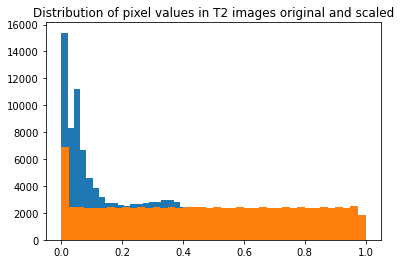

In [48]:
px1 = TensorDicom3D(im1.flatten())
plt.hist(px1.numpy(), bins = 40)
plt.hist(px1.hist_scaled().numpy(), bins = 40)
plt.title("Distribution of pixel values in T2 images original and scaled") 
plt.show()

The pixels are now all nearly equally distributed. 

In [49]:
im1 = TensorDicom3D(im1)
im2 = TensorDicom3D(im2)

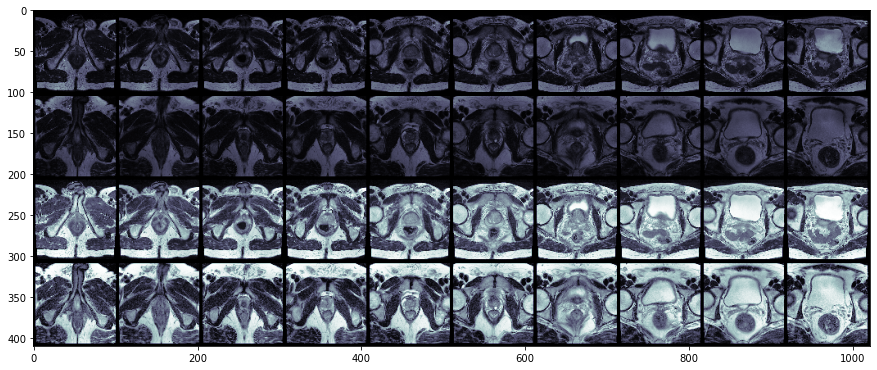

In [50]:
show_multiple_3d_images(torch.stack((im1, im2, im1.hist_scaled(), im2.hist_scaled()), axis = 0), nrow = 10)

I belive both steps should executed after reading the images, even before cropping and resizing, thus they will be directly integrated into the `read_medical_3d_image` function. 

In [51]:
#export
def normalize(t: Tensor):
    return (t - t.mean())/t.std()

In [52]:
normalize(im).mean(), normalize(im).std()

(tensor(1.1631e-07), tensor(1.))

(torch.Size([31, 736, 736]), None)

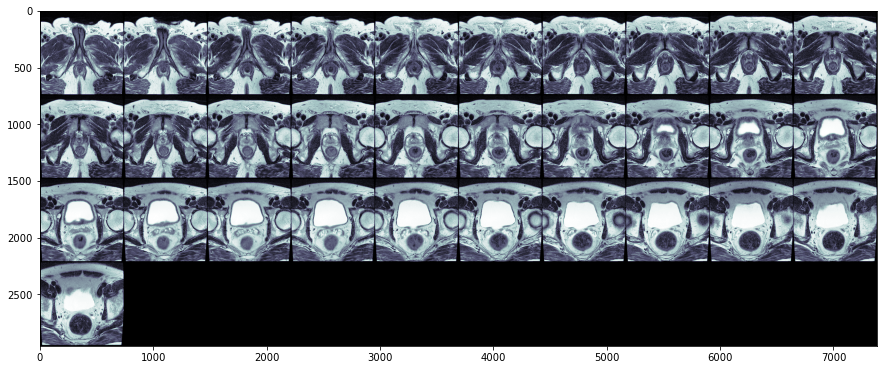

In [53]:
im = read_medical_3d_image('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/DICOM', return_scaled=True, return_normalized=True)
im.shape, show_one_3d_image(im, axis = 0, nrow = 10)

# Rendering 3D Objects

Somtimes the mask is better viewed as 3D object. Rendering is implemented as described in this example: https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html
A faster, more felxible way might be using [ipyvolume](https://github.com/maartenbreddels/ipyvolume/) or [vtk](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/). 

To implement 3D rendering for the mask, the TensorMask3D class needs to be expanded

In [316]:
# export
class TensorMask3D(TensorDicom3D):
    "Base class for 3d Segmentation, inherits from TensorDicom3D"
    
    def get_nonzero_bool(self):
        """
        Identifies non-zero planes alongsinde an axis of a 3D `Tensor`. 
        Returns a 1D boolean `Tensor`. 
        """
        
        z = torch.sum(self.abs(), dim=(1,2)) != 0
        x = torch.sum(self.abs(), dim=(0,2)) != 0
        y = torch.sum(self.abs(), dim=(0,1)) != 0
        return z, x, y
    
    def get_center_id(self, x):
        """
        In a `Tensor` with a sequence of values which are not zero, return the index of the (approx.) central value: 
        
        example:
        x = tensor([0, 0, 0, 1, -3, 1, 4, 1, 0, 0])
        get_center_point(x)
        >>> tensor(5)
        """        
        return x.nonzero().squeeze().median()

    
    def get_strip_idx(self, symmetric):
        """
        Calculated axis-ids to strip zero-planes from `Tensor`
        
        Args:
            symmetric: whether H and W of `Tensor` should be the same after stripping. 
            
        Returns:
            ID of the axis which is closest to the region of interest but still zero
            
        Example: 
            t = torch.zeros(5,9,9)
            t[3,5,5] = 1
            get_strip_idx(t)
            >>> 2,4,4,6,4,6
        """
        
        z, x, y = self.get_nonzero_bool()
        
        center_z = self.get_center_id(z)
        center_x = self.get_center_id(x)
        center_y = self.get_center_id(y)
        
        if symmetric: 
            if x.sum() > y.sum(): y = x
            if y.sum() > x.sum(): x = y
        
        z1, z2 = self._get_idx(center_z, z)
        x1, x2 = self._get_idx(center_x, x)
        y1, y2 = self._get_idx(center_y, y)
                
        return (z1,z2,x1,x2,y1,y2)
        
    def _get_idx(self, c, nonzero_bool):
        min = c - torch.true_divide(nonzero_bool.sum(), 2).ceil()
        max = c + torch.true_divide(nonzero_bool.sum(), 2).ceil()
        if min < 0: 
            max -= min
            min -= min 
        if max > len(nonzero_bool):
            min -= (tensor(len(nonzero_bool)) - max)
            max = tensor(len(nonzero_bool))
        return min.long(), max.long()
    
    def strip(self, pad_x=0, pad_y=0, pad_z=0, pad_xy=None, symmetric = True):
        """
        Reduces a 3D `Tensor` in size through removing 2D planes which are all 0. 
        This is usefull if the segmented region of interest is only a small part
        in the 3D volume (e.g. kidney in an abominal CT).
        
        Args:
            pad_x, pad_y, pad_z: added to margins, to keep a small margin of zero-planes. 
            pad_xy: can be used instead of passing the same number to pad_x and pad_y
            symmetric: whether the resulting size of the `Tensor` should be the same for H and W. 
        
        Returns: 
            A `Tensor` stripped of its zero-margins. 
        
        Procedure: 
            [get strip idx] -> [add padding] -> [strip] 
        """
        
        if hasattr(self, 'strip_idx'): 
            z1,z2,x1,x2,y1,y2 = self.strip_idx      
        else:
            z1,z2,x1,x2,y1,y2 = self.get_strip_idx(symmetric=symmetric)
        
        if pad_xy is not None:
            pad_x, pad_y = pad_xy, pad_xy
            
        def pad(lwr, upr, pad):
            "does only correct to small but not to large value"
            lwr -= pad
            upr  += pad
            if lwr < 0: 
                lwr -= lwr
                upr -= lwr
            return lwr, upr
    
        x1,x2 = pad(x1, x2, pad_x)
        y1,y2 = pad(y1, y2, pad_y)
        z1,z2 = pad(z1, z2, pad_z)
    
        return self._do_strip(x1,x2,y1,y2,z1,z2)
        
    def _do_strip(self, x1,x2,y1,y2,z1,z2):
        stripped_mask = self[z1:z2, x1:x2, y1:y2]
        return TensorMask3D(stripped_mask)
    
    def create_mesh(self, cl, color, alpha):    
        "creates a 3D mesh for a single class in the 3D Tensor"
        
        if self.ndim != 3: raise NotImplementedError('Currently only rank 3 tensors are supported for rendering')
        
        from skimage.measure import marching_cubes_lewiner
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        
        im = (self == cl).float()
        
        verts, faces, normals, values = marching_cubes_lewiner(im.permute(1, 2, 0).numpy())
        mesh = Poly3DCollection(verts[faces])
        mesh.set_facecolor(color)
        mesh.set_alpha(alpha)
        return mesh
    
    def show_center_point(self):
        "displays a cross in the center of the mask"
        z, x, y = self.get_nonzero_bool()
        center_z = self.get_center_id(z)
        center_x = self.get_center_id(x)
        center_y = self.get_center_id(y)
        c_val = im.max()+2
        self[center_z, center_x-50:center_x+50, center_y-5:center_y+5] = c_val
        self[center_z, center_x-5:center_x+5, center_y-50:center_y+50] = c_val
        self.show()
    
    def create_mesh_for_classes(self, colors, alpha): 
        "applies `create_mesh` to all classes of the mask"
        classes = self.unique()[1:]
        if colors is None:
            colors = 'bgrcmyw'
            
            if len(classes) > len(colors):
                colors = random.choices(colors, k=len(classes))
            
            else:
                colors = colors[0:len(classes)]
                
        if alpha is None: alpha = (0.5, )*len(classes)     
        if type(alpha) is not tuple: raise TypeError('alpha need to be a tuple.') 
        if len(alpha) == 1: alpha = alpha*len(classes)
        if len(alpha) != len(classes): 
            raise ValueError('Number of classes and number of alpha does not match')
            
        cca = list(zip(classes, colors, alpha))
        
        meshes = [self.create_mesh(cl=cl, color=color, alpha=alpha) for cl, color, alpha in cca]
        return meshes
    
    def render_3d(self, colors=None, alpha = None, symmetric=False):
        "renders the mask as a 3D object and displays it"
        
        im = self.strip(symmetric = symmetric)
        meshes = im.create_mesh_for_classes(colors = colors, alpha = alpha)
        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        for m in meshes: ax.add_collection3d(m)

        ax.set_xlim(0, im.size(1)) 
        ax.set_ylim(0, im.size(2))  
        ax.set_zlim(0, im.size(0))  
        ax.set_facecolor('k')

        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def calc_volume(self):
        """
        Calcualtes the volume for a single class in the mask. 
        Calculation relies on correct spacing onformation in the header.
        Results are given in mm**3
        """
        x,y,z = self.metadata['spacing']
        voxel_size = x*y*z
        
        self.volume = {'background': self._calc_vol_per_class(0, voxel_size)}
        self.volume['total_mask_volume'] = self.size(0)*self.size(1)*self.size(2)*voxel_size - self.volume['background']
        
        for c in self.unique()[1:]:
            name = 'class '+str(int(c))
            self.volume[name] = self._calc_vol_per_class(c, voxel_size)
        
        print(self.volume)
         
    def _calc_vol_per_class(self, class_idx, voxel_size):
        "calculates volume of the void, whole mask and for each class in the mask"
        return float((self == class_idx).sum() * voxel_size)
        

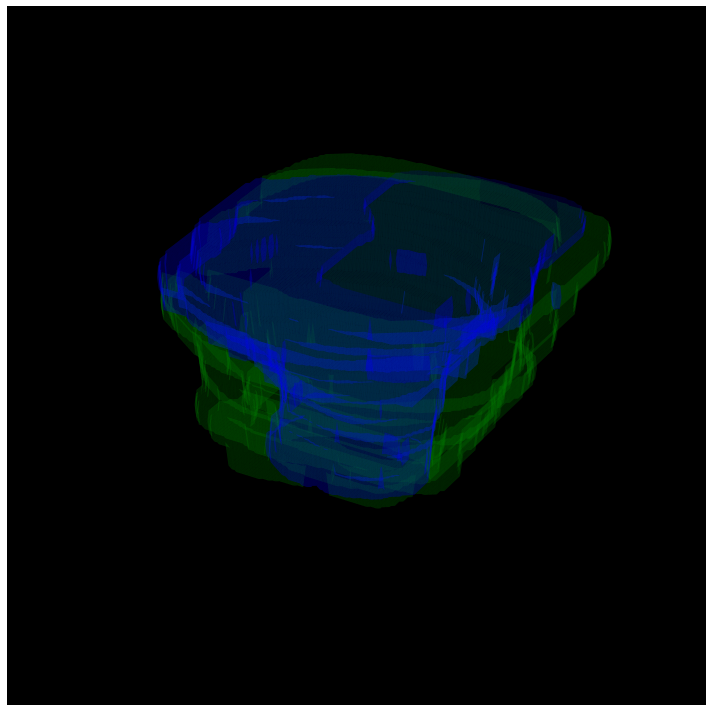

In [318]:
im  = TensorMask3D.create('../../dl-prostate-mapping/data/train/Gesund/A0042197734/T2/Annotation/Annotation.nii.gz')       
im.render_3d(alpha = (0.15, 0.15))

In [322]:
im.calc_volume()

{'background': 3694497.25, 'total_mask_volume': 25414.79155157879, 'class 1': 12753.419921875, 'class 2': 12661.4892578125}
